In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import datetime
import pandas as pd
from catboost import Pool
from collections import Counter
import ast
import numpy as np


In [2]:
def drop(df,col):
    df = df.drop(columns=col)
    return df

In [3]:
# Convertir a diccionario limpio
def clean_counter(x):
    if isinstance(x, str) and x.startswith("Counter("):
        try:
            return ast.literal_eval(x.replace("Counter(", "").rstrip(")"))
        except:
            return {}
    elif isinstance(x, Counter):
        return dict(x)
    elif isinstance(x, dict):
        return x
    else:
        return {}

In [4]:
def clipping(df, cols, perc):
    for col in cols:
        p = df[col].quantile(perc)
        df[col] = df[col].clip(upper=p)
    return df

In [5]:
# Cargar los datos
df = pd.read_csv("../../data/processed/train_preprocess_v1.csv")
test_df = pd.read_csv("../../data/processed/test_preprocess_v1.csv")

df.shape

# Creamos un df_train sobre el que hacer las transformaciones
train_df = df.copy()

In [6]:
df.head(2)

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_affiliation_uni,party_affiliation_category_map,...,pos_info_without_stopwords,pos_freq_without_stopwords,lemma_freq_without_stopwords,tag_freq_without_stopwords,processed_subject,speaker_entities,speaker_type,speaker_job_tokens,state_info_tokens,party_affiliation_tokens
0,81f884c64a7,1,china is in the south china sea and (building)...,"china,foreign-policy,military",donald-trump,president-elect,new_york,republican,republican,political-affiliation,...,"[{'lemma': 'china', 'pos': 'PROPN', 'tag': 'NN...","Counter({'PROPN': 4, 'NOUN': 4, 'ADJ': 1, 'VER...","Counter({'china': 2, 'south': 1, 'sea': 1, 'bu...","Counter({'NNP': 4, 'NN': 3, 'JJ': 1, 'NNS': 1,...","['china', 'foreign-policy', 'military']",['donald trump'],['PERSON'],"['president', '-', 'elect']",['new_york'],['republican']
1,30c2723a188,0,with the resources it takes to execute just ov...,health-care,chris-dodd,u.s. senator,connecticut,democrat,democrat,political-affiliation,...,"[{'lemma': 'resource', 'pos': 'NOUN', 'tag': '...","Counter({'NOUN': 7, 'VERB': 4, 'PROPN': 2, 'AD...","Counter({'resource': 1, 'take': 1, 'execute': ...","Counter({'NN': 4, 'NNS': 3, 'VB': 2, 'NNP': 2,...",['health-care'],['chris dodd'],['PERSON'],"['u.s', '.', 'senator']",['connecticut'],['democrat']


## Selección de categorías

A continuación se describen brevemente las características útiles para el modelo:

### id

La variable `id` carece de poder descriptivo. En el caso del test, hay que guardarla.

In [7]:
df_test_id = test_df["id"]

In [8]:
col = "id"
train_df = drop(train_df,col)
test_df = drop(test_df,col)

### Statement 

La variable `statement` resulta muy útil para el modelo. En este caso, se declarará como variable de tipo texto para que CatBoost la identifique como tal y le aplique el procesamiento nativo adecuado.

### Variables derivadas del procesado de Statement

En relación con `statement`, tenemos `statement_tokens`, que no es procesable nativamente para CatBoost. Como ya se va a representar el efecto del statement con la variable original, se elimina del modelo. Su variante sin stopwords, también se quita, y la lista de stopwords también.

In [9]:
# quitamos caracteres especiales
train_df['statement'] = df['statement'].str.replace(r'[^\w\s]', '', regex=True)
test_df['statement'] = test_df['statement'].str.replace(r'[^\w\s]', '', regex=True)

### `statement_tokens` y `statement_tokens_without_stopwords`

Se podría evaluar su rendimiento en sustitución de `statement` procesada por CatBoost. Se verá más adelante. Gracias al procesamiento nativo de CatBoost de variables de tipo texto, obtiene de forma natural estadísticas derivadas de la tokenización, por lo que eliminaremos estas variables y nos quedaremos con las que tienen significado en términos de análisis linguístico. 

`statement_tokens`

In [10]:
train_df["statement_tokens"]

0       china is in the south china sea and ( building...
1       with the resources it takes to execute just ov...
2       the ( wisconsin ) governor has proposed tax gi...
3       says her representation of an ex - boyfriend w...
4       at protests in wisconsin against proposed coll...
                              ...                        
8945    if rhode island does a hybrid [ retirement ] p...
8946    the new health care law will force seniors int...
8947    the health insurance plan that ( members of co...
8948    no one in american history has moved from a ju...
8949    says the army is spending $ 7 million to spons...
Name: statement_tokens, Length: 8950, dtype: object

Obtenemos la versión `string` de `statement_tokens`

In [11]:
# Transformamos a lista, quitando caracteres especiales
train_df['statement_tokens'] = df['statement_tokens'].str.replace(r'[^\w\s]', '', regex=True).str.split()
# Concatenamos para convertirlo a texto
train_df["statement_text"] = train_df["statement_tokens"].apply(lambda x: " ".join(x))
train_df["statement_text"]

0       china is in the south china sea and buildinga ...
1       with the resources it takes to execute just ov...
2       the wisconsin governor has proposed tax giveaw...
3       says her representation of an ex boyfriend who...
4       at protests in wisconsin against proposed coll...
                              ...                        
8945    if rhode island does a hybrid retirement plan ...
8946    the new health care law will force seniors int...
8947    the health insurance plan that members of cong...
8948    no one in american history has moved from a ju...
8949    says the army is spending 7 million to sponsor...
Name: statement_text, Length: 8950, dtype: object

Hacemos lo mismo con los `tokens`sin `stopwords`

In [12]:
train_df['statement_tokens_no_stopwords'] = df['statement_tokens_without_stopwords'].str.replace(r'[^\w\s]', '', regex=True).str.split()
train_df["statement_text_no_stopwords"] = train_df["statement_tokens_no_stopwords"].apply(lambda x: " ".join(x))
train_df["statement_text_no_stopwords"]

0       china south china sea buildinga military fortr...
1       resources takes execute months iraq war fully ...
2       wisconsin governor proposed tax giveaways corp...
3       says representation ex boyfriend friend family...
4       protests wisconsin proposed collective bargain...
                              ...                        
8945     rhode island hybrid retirement plan state nation
8946    new health care law force seniors barack obama...
8947    health insurance plan members congress differe...
8948    american history moved june announcement winni...
8949       says army spending million sponsor nascar team
Name: statement_text_no_stopwords, Length: 8950, dtype: object

Y el mismo procesado para test


In [13]:
# statement_tokens
test_df['statement_tokens'] = test_df['statement_tokens'].str.replace(r'[^\w\s]', '', regex=True).str.split()
test_df["statement_text"] = test_df["statement_tokens"].apply(lambda x: " ".join(x))

# statement_tokens sin stopwords
test_df['statement_tokens_no_stopwords'] = test_df['statement_tokens_without_stopwords'].str.replace(r'[^\w\s]', '', regex=True).str.split()
test_df["statement_text_no_stopwords"] = test_df["statement_tokens_no_stopwords"].apply(lambda x: " ".join(x))

Así quedan eliminadas las listas de tokens para estas variables, que no son procecsables de forma nativa para CatBoost. Al usarlo en el modelo, se prioriza la versión con stopwords porque contiene el contexto del statement, pero se ha observado overfitting por lo que se deja sin ellas también para evaluar más adelante

In [14]:
# los tokens no son procesables para catboost
train_df = train_df.drop(columns=["statement_tokens","statement_tokens_without_stopwords"])
test_df= test_df.drop(columns=["statement_tokens","statement_tokens_without_stopwords"])

### `num_tokens` y `num_tokens_without_stopwords`

Contienen información del número de palabras en un stamente, con y sin stepwords. Se puede obtener el número de tokens que son stopwords, por si tuviera poder predictivo. Lo largo que es un statement puede estar relacionado con fake news

In [15]:
train_df["num_stopwords_tokens"] = train_df["num_tokens"] - train_df["num_tokens_without_stopwords"]
test_df["num_stopwords_tokens"] = test_df["num_tokens"] - test_df["num_tokens_without_stopwords"]

Se valora si existen outliers

In [16]:
train_df.describe()

,label,num_tokens,num_sentences,num_tokens_without_stopwords,num_stopwords_tokens
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,0.647486,20.810838,1.136983,10.147933,10.662905
std,0.477780,13.179739,0.469908,7.396729,6.785641
min,0.000000,2.000000,1.000000,1.000000,0.000000
25%,0.000000,14.000000,1.000000,7.000000,6.000000
50%,1.000000,19.000000,1.000000,9.000000,10.000000
75%,1.000000,26.000000,1.000000,12.000000,14.000000
max,1.000000,789.000000,14.000000,490.000000,299.000000


Se reducen a los percentiles 75, para eliminar ruido. Se realiza clipping:

In [17]:
# Seleccionar las columnas que empiezan con 'num_' y aplicar clipping
num_cols = [col for col in train_df.columns if col.startswith('num_')]
train_df = clipping(train_df, num_cols, 0.75)
train_df.describe()

,label,num_tokens,num_sentences,num_tokens_without_stopwords,num_stopwords_tokens
count,8950.000000,8950.000000,8950.0,8950.000000,8950.000000
mean,0.647486,18.951061,1.0,9.112849,9.493631
std,0.477780,5.870131,0.0,2.669110,3.693098
min,0.000000,2.000000,1.0,1.000000,0.000000
25%,0.000000,14.000000,1.0,7.000000,6.000000
50%,1.000000,19.000000,1.0,9.000000,10.000000
75%,1.000000,26.000000,1.0,12.000000,14.000000
max,1.000000,26.000000,1.0,12.000000,14.000000


Se aplica al test:

In [18]:
num_cols = [col for col in test_df.columns if col.startswith('num_')]
test_df = clipping(test_df, num_cols, 0.75)

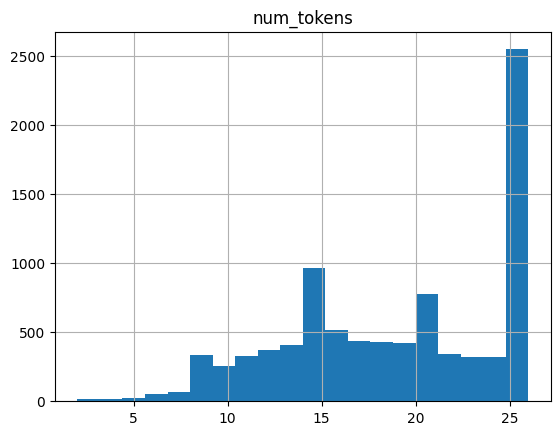

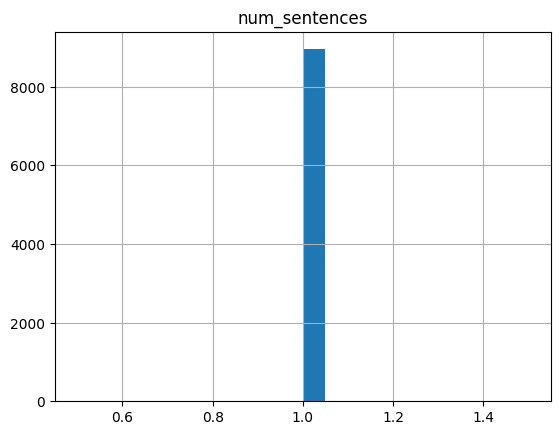

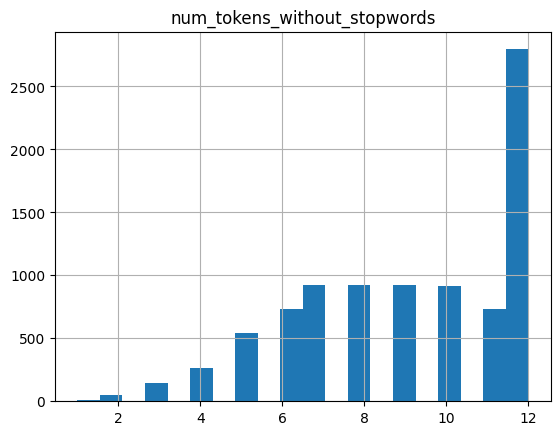

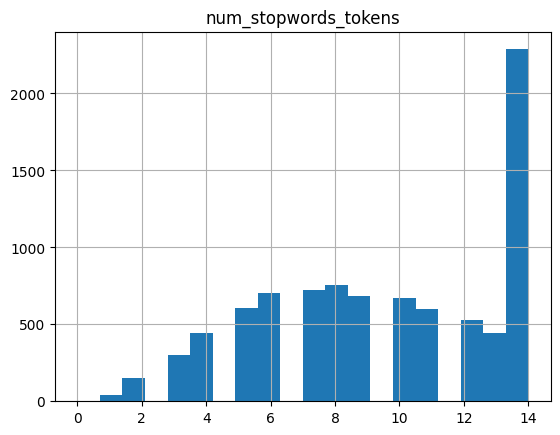

In [19]:
import matplotlib.pyplot as plt

for col in num_cols:
    train_df[col].hist(bins=20)
    plt.title(col)
    plt.show()

Las variables `num_tokens_without_stopwords`y su contraria funcionarían como variables categóricas por su baja cardinalidad. Por otro lado, el `num_tokens`

In [20]:
train_df["num_tokens"].unique()

array([23, 26, 12, 24, 11, 10, 20, 14, 13, 18, 25, 21, 19, 16,  9, 15, 22,
        8, 17,  7,  6,  5,  3,  4,  2])

No tiene una cardinalidad excesiva pero se puede agrupar

In [21]:
def group_num_token(num):
    if num < 5:
        return "<5"
    elif 5 <= num < 10:
        return "5-10"
    elif 10 <= num < 15:
        return "10-15"
    elif 15 <= num < 20:
        return "15-20"
    elif 20 <= num < 25:
        return "20-25"
    else:
        return ">25"

train_df['num_tokens_group'] = train_df['num_tokens'].apply(group_num_token)
train_df['num_tokens_group'].nunique()

test_df['num_tokens_group'] = test_df['num_tokens'].apply(group_num_token)

Como se representa en la variable agrupada, se eliminan las variables numéricas, aunque CatBoost presentan soporte nativo para ellos y podrían dejarse.

In [22]:
train_df = drop(train_df,"num_tokens")
test_df = drop(test_df,"num_tokens")

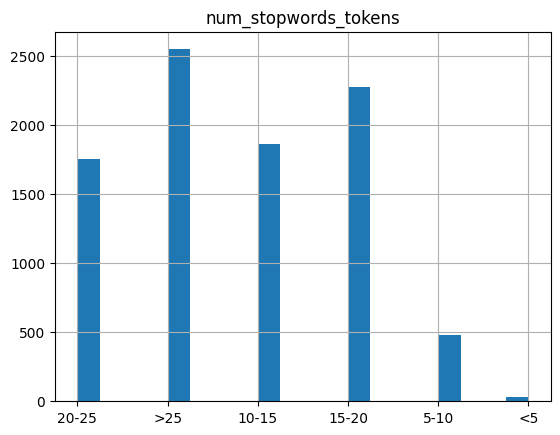

In [23]:
train_df["num_tokens_group"].hist(bins=20)
plt.title(col)
plt.show()

Observarmos la distribución de label

  num_tokens_group  freq      rate
0            10-15  1862  0.638561
1            15-20  2274  0.645998
2            20-25  1755  0.638746
3             5-10   482  0.746888
4               <5    30  0.866667
5              >25  2547  0.639969


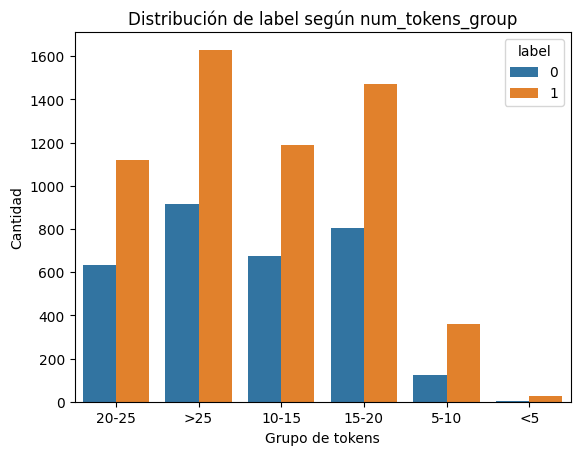

In [24]:
summary = (
    train_df.groupby('num_tokens_group')['label']
    .agg(freq='count', rate='mean')
    .reset_index()
)
print(summary)
import seaborn as sns
import matplotlib.pyplot as plt

# Frecuencia por grupo
sns.countplot(data=train_df, x='num_tokens_group', hue='label')
plt.title('Distribución de label según num_tokens_group')
plt.xlabel('Grupo de tokens')
plt.ylabel('Cantidad')
plt.show()


In [25]:
train_df.columns.tolist()

['label',
 'statement',
 'subject',
 'speaker',
 'speaker_job',
 'state_info',
 'party_affiliation',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'num_sentences',
 'pos_info',
 'pos_freq',
 'lemma_freq',
 'tag_freq',
 'entities',
 'stopwords',
 'num_tokens_without_stopwords',
 'pos_info_without_stopwords',
 'pos_freq_without_stopwords',
 'lemma_freq_without_stopwords',
 'tag_freq_without_stopwords',
 'processed_subject',
 'speaker_entities',
 'speaker_type',
 'speaker_job_tokens',
 'state_info_tokens',
 'party_affiliation_tokens',
 'statement_text',
 'statement_tokens_no_stopwords',
 'statement_text_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group']

In [26]:
train_df = drop(train_df,"stopwords")
test_df = drop(test_df,"stopwords")

### `num_sentences`

En la gráfica anterior, vemos que todas las variables tienen valor 1, por lo que se descarta del dataset. 

In [27]:
train_df = drop(train_df,"num_sentences")
test_df = drop(test_df,"num_sentences")

#### POS

Tenemos `pos_info` y `pos_freq`, con sus variantes `without_stopwords`. 

In [28]:
df["pos_info"].head(2)

0    [{'lemma': 'china', 'pos': 'PROPN', 'tag': 'NN...
1    [{'lemma': 'with', 'pos': 'ADP', 'tag': 'IN', ...
Name: pos_info, dtype: object

In [29]:
df["pos_freq"].head(2)

0    Counter({'PROPN': 4, 'NOUN': 4, 'DET': 3, 'AUX...
1    Counter({'NOUN': 7, 'ADP': 5, 'VERB': 4, 'DET'...
Name: pos_freq, dtype: object

`pos_info`contiene la clasificación de palabras del statement, y `pos_freq`el número de palabras de cada tipo. Se va a tratar de representar el estilo de lenguaje a través de métricas obtenidas de estas variables: 

In [30]:
print(train_df.shape)

# Aplicar la conversión a listas con y sin stopwords
train_df["pos_freq_clean"] = train_df["pos_freq"].apply(clean_counter)
train_df["pos_freq_without_stopwords_clean"] = train_df["pos_freq_without_stopwords"].apply(clean_counter)

test_df["pos_freq_clean"] = test_df["pos_freq"].apply(clean_counter)
test_df["pos_freq_without_stopwords_clean"] = test_df["pos_freq_without_stopwords"].apply(clean_counter)

# Expandir en columnas
pos_df = train_df["pos_freq_clean"].apply(pd.Series).fillna(0).astype(int)
pos_df_wo_stopwords = train_df["pos_freq_without_stopwords_clean"].apply(pd.Series).fillna(0).astype(int)

pos_df_test = train_df["pos_freq_clean"].apply(pd.Series).fillna(0).astype(int)
pos_df_wo_stopwords_test = train_df["pos_freq_without_stopwords_clean"].apply(pd.Series).fillna(0).astype(int)

# Renombrar columnas
pos_df.columns = [f"pos_count_{col.upper()}" for col in pos_df.columns]
pos_df_wo_stopwords.columns = [f"pos_{col.upper()}" for col in pos_df_wo_stopwords.columns]

pos_df_test.columns = [f"pos_count_{col.upper()}" for col in pos_df_test.columns]
pos_df_wo_stopwords_test.columns = [f"pos_{col.upper()}" for col in pos_df_wo_stopwords_test.columns]

pos_df.head(2)

(8950, 30)


,pos_count_PROPN,pos_count_NOUN,pos_count_DET,pos_count_AUX,pos_count_ADP,pos_count_PUNCT,pos_count_CCONJ,pos_count_ADJ,pos_count_PRON,pos_count_ADV,pos_count_PART,pos_count_VERB,pos_count_NUM,pos_count_SCONJ,pos_count_SYM,pos_count_X,pos_count_INTJ,pos_count_SPACE
0,4,4,3,2,2,2,1,1,1,1,1,1,0,0,0,0,0,0
1,2,7,3,1,5,2,0,1,3,2,1,4,1,0,0,0,0,0


In [31]:
pos_df_wo_stopwords.head(2)

,pos_PROPN,pos_NOUN,pos_ADJ,pos_VERB,pos_ADV,pos_NUM,pos_AUX,pos_SCONJ,pos_SYM,pos_PART,pos_PRON,pos_X,pos_ADP,pos_INTJ,pos_DET,pos_CCONJ,pos_PUNCT,pos_SPACE
0,4,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,7,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0


No se añaden al dataset directamente porque se ha visto en modelos anteriores que la influencia de estas variables es baja. Se podría hacer ingeniería de características. Se eliminan las versiones limpias.

In [32]:
train_df = train_df.drop(columns=["pos_freq_clean","pos_freq_without_stopwords_clean"])
test_df = test_df.drop(columns=["pos_freq_clean","pos_freq_without_stopwords_clean"])

Se observa su frecuencia por si fuera interesante reducir cardinalidad.

Observamos los percentiles y vemos que en muchos casos el percentil 75 es muy agresivo. En todas las categorías funciona un percentil 99. No obstante, las gráficas están enmascaradas por la proporción de clases, ya que el dataset está desbalanceado.

In [33]:
pos_df_wo_stopwords.describe(percentiles=[0.75, 0.80, 0.85, 0.90, 0.95, 0.99])

,pos_PROPN,pos_NOUN,pos_ADJ,pos_VERB,pos_ADV,pos_NUM,pos_AUX,pos_SCONJ,pos_SYM,pos_PART,pos_PRON,pos_X,pos_ADP,pos_INTJ,pos_DET,pos_CCONJ,pos_PUNCT,pos_SPACE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1.684804,4.621564,1.032849,2.033184,0.213631,0.250726,0.040335,0.004022,0.124804,0.051732,0.007374,0.005028,0.032849,0.003575,0.006369,0.001788,0.000782,0.032514
std,1.898351,3.113117,1.172102,1.446137,0.475049,0.604428,0.220838,0.063298,0.394338,0.242682,0.085561,0.079650,0.182587,0.061535,0.079554,0.042246,0.027957,2.107130
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,6.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
80%,3.000000,6.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85%,3.000000,7.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90%,4.000000,8.000000,2.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,5.000000,9.000000,3.000000,5.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
pos_df_wo_stopwords = clipping(pos_df_wo_stopwords, pos_df_wo_stopwords.columns.tolist(), 0.99)
pos_df_wo_stopwords.describe()

pos_df_wo_stopwords_test = clipping(pos_df_wo_stopwords_test, pos_df_wo_stopwords_test.columns.tolist(), 0.99)
pos_df_wo_stopwords_test.describe()

,pos_PROPN,pos_NOUN,pos_ADJ,pos_VERB,pos_ADV,pos_NUM,pos_AUX,pos_SCONJ,pos_SYM,pos_PART,pos_PRON,pos_X,pos_ADP,pos_INTJ,pos_DET,pos_CCONJ,pos_PUNCT,pos_SPACE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.0,8950.000000,8950.000000,8950.0,8950.0,8950.000000,8950.0,8950.0,8950.0,8950.0,8950.0
mean,1.659218,4.577207,1.015419,2.018659,0.210391,0.240994,0.035978,0.0,0.122123,0.047374,0.0,0.0,0.032067,0.0,0.0,0.0,0.0,0.0
std,1.605131,2.395524,1.033892,1.370061,0.456736,0.540691,0.186245,0.0,0.376051,0.212450,0.0,0.0,0.176188,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
50%,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
75%,2.000000,6.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
max,7.000000,12.000000,4.000000,6.000000,2.000000,2.510000,1.000000,0.0,2.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0


Algunas de las variables solo tienen un valor. Filtramos y eliminamos.

In [35]:
# Detectar columnas con un único valor
cols_with_one_value = [col for col in pos_df_wo_stopwords.columns.tolist() if pos_df_wo_stopwords[col].nunique() == 1]

# Eliminar esas columnas del DataFrame
pos_df_wo_stopwords = pos_df_wo_stopwords.drop(columns=cols_with_one_value)
pos_df_wo_stopwords.describe()

# Eliminar esas columnas del DataFrame del test
pos_df_wo_stopwords_test = pos_df_wo_stopwords_test.drop(columns=cols_with_one_value)
pos_df_wo_stopwords_test.describe()

,pos_PROPN,pos_NOUN,pos_ADJ,pos_VERB,pos_ADV,pos_NUM,pos_AUX,pos_SYM,pos_PART,pos_ADP
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1.659218,4.577207,1.015419,2.018659,0.210391,0.240994,0.035978,0.122123,0.047374,0.032067
std,1.605131,2.395524,1.033892,1.370061,0.456736,0.540691,0.186245,0.376051,0.212450,0.176188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,6.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,12.000000,4.000000,6.000000,2.000000,2.510000,1.000000,2.000000,1.000000,1.000000


Representamos para ver las distribuciones

In [36]:
common_cols = list(set(pos_df_wo_stopwords.columns) & set(train_df.columns))
#plot_distribution_and_label_proportion(train_df, common_cols, label='label')

In [37]:
drop_cols = ["pos_info","pos_freq","pos_info_without_stopwords","pos_freq_without_stopwords"]
train_df = train_df.drop(columns = drop_cols)
test_df = test_df.drop(columns = drop_cols)

In [38]:
train_df.columns.tolist()

['label',
 'statement',
 'subject',
 'speaker',
 'speaker_job',
 'state_info',
 'party_affiliation',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'lemma_freq',
 'tag_freq',
 'entities',
 'num_tokens_without_stopwords',
 'lemma_freq_without_stopwords',
 'tag_freq_without_stopwords',
 'processed_subject',
 'speaker_entities',
 'speaker_type',
 'speaker_job_tokens',
 'state_info_tokens',
 'party_affiliation_tokens',
 'statement_text',
 'statement_tokens_no_stopwords',
 'statement_text_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group']

#### Lemma

In [39]:
# Aplicar a ambas columnas
train_df["lemma_freq_clean"] = df["lemma_freq"].apply(clean_counter)
test_df["lemma_freq_clean"] = test_df["lemma_freq"].apply(clean_counter)

# Expandir lemas
lemma_df = train_df["lemma_freq_clean"].apply(pd.Series).fillna(0).astype(int)
lemma_df.columns = [f"lemma_count_{col}" for col in lemma_df.columns]
lemmas_cols = lemma_df.columns.tolist()
len(lemmas_cols)

lemma_df_test = test_df["lemma_freq_clean"].apply(pd.Series).fillna(0).astype(int)
lemma_df_test.columns = [f"lemma_count_{col}" for col in lemma_df_test.columns]
lemmas_cols_test = lemma_df_test.columns.tolist()
len(lemmas_cols_test)

6434

La cardinalidad de es altísima en `lemma`, por lo que probamos sin `stopwords`: 

In [40]:
train_df["lemma_freq_without_stopwords"] = df["lemma_freq_without_stopwords"].apply(clean_counter)
lemma_df = train_df["lemma_freq_without_stopwords"].apply(pd.Series).fillna(0).astype(int)
lemma_df.columns = [f"lemma_count_{col}" for col in lemma_df.columns]

lemmas_cols = [col for col in lemma_df.columns.tolist() if col.startswith('lemma_count')]
len(lemmas_cols)

test_df["lemma_freq_without_stopwords"] = test_df["lemma_freq_without_stopwords"].apply(clean_counter)
lemma_df_test = test_df["lemma_freq_without_stopwords"].apply(pd.Series).fillna(0).astype(int)
lemma_df_test.columns = [f"lemma_count_{col}" for col in lemma_df_test.columns]

lemmas_cols_test = [col for col in lemma_df_test.columns.tolist() if col.startswith('lemma_count')]
len(lemmas_cols_test)

5967

Se reduce la cardinalidad, pero no suficiente. Se considera reducir la variable al número de lemmas presentes en el statement, sin stopwords. Para ello, se establecen contadores: 

In [41]:
train_df['lemma_count'] = train_df['lemma_freq'].apply(len)
train_df["lemma_count"].nunique() #446
train_df["lemma_count"].describe()

test_df['lemma_count'] = test_df['lemma_freq'].apply(len)

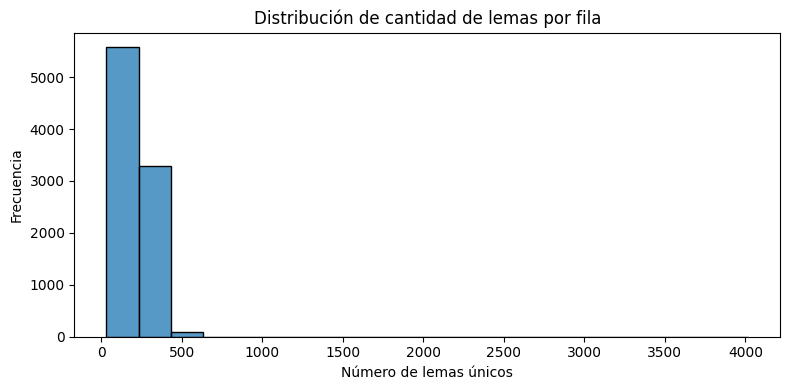

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(train_df['lemma_count'], bins=20, kde=False)
plt.title('Distribución de cantidad de lemas por fila')
plt.xlabel('Número de lemas únicos')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


In [43]:
train_df["lemma_freq_without_stopwords"]
train_df['lemma_count_no_stopwords'] = train_df['lemma_freq_without_stopwords'].apply(len)
train_df["lemma_count_no_stopwords"].describe()

test_df["lemma_freq_without_stopwords"]
test_df['lemma_count_no_stopwords'] = test_df['lemma_freq_without_stopwords'].apply(len)

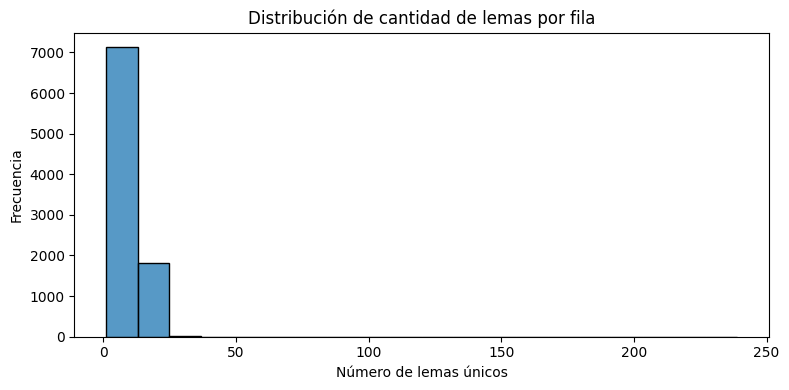

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(train_df['lemma_count_no_stopwords'], bins=20, kde=False)
plt.title('Distribución de cantidad de lemas por fila')
plt.xlabel('Número de lemas únicos')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


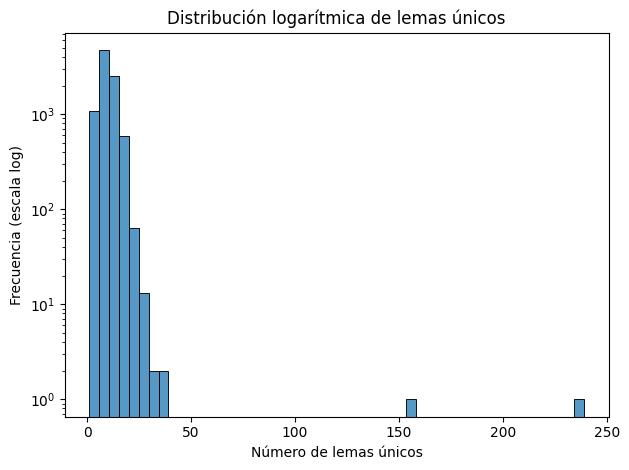

In [45]:
sns.histplot(train_df['lemma_count_no_stopwords'], bins=50)
plt.yscale('log')  # para ver detalles en conteos bajos
plt.title('Distribución logarítmica de lemas únicos')
plt.xlabel('Número de lemas únicos')
plt.ylabel('Frecuencia (escala log)')
plt.tight_layout()
plt.show()

Por su distribución y para paliar outliers sin quitar muestras, se agrupan en bins:

In [46]:
def lemma_bin(n):
    if n == 0:
        return 'sin lemas'
    elif n <= 10:
        return '1–10'
    elif n <= 20:
        return '11–20'
    elif n <= 30:
        return '21–30'
    elif n <= 50:
        return '31–50'
    else:
        return 'más de 50'

train_df['lemma_bin'] = train_df['lemma_count'].apply(lemma_bin)
train_df['lemma_bin_no_stopwords'] = train_df['lemma_count_no_stopwords'].apply(lemma_bin)

test_df['lemma_bin'] = test_df['lemma_count'].apply(lemma_bin)
test_df['lemma_bin_no_stopwords'] = test_df['lemma_count_no_stopwords'].apply(lemma_bin)

In [47]:
train_df.columns.tolist()

['label',
 'statement',
 'subject',
 'speaker',
 'speaker_job',
 'state_info',
 'party_affiliation',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'lemma_freq',
 'tag_freq',
 'entities',
 'num_tokens_without_stopwords',
 'lemma_freq_without_stopwords',
 'tag_freq_without_stopwords',
 'processed_subject',
 'speaker_entities',
 'speaker_type',
 'speaker_job_tokens',
 'state_info_tokens',
 'party_affiliation_tokens',
 'statement_text',
 'statement_tokens_no_stopwords',
 'statement_text_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group',
 'lemma_freq_clean',
 'lemma_count',
 'lemma_count_no_stopwords',
 'lemma_bin',
 'lemma_bin_no_stopwords']

In [48]:
# Limpiamos las columnas que catboost no puede procesar:
drop_cols = ["lemma_freq","lemma_freq_without_stopwords","lemma_freq_clean"]
train_df = train_df.drop(columns = drop_cols)
test_df = test_df.drop(columns = drop_cols)

### tags

In [49]:
# Expandir tags
train_df["tag_freq_clean"] = df["tag_freq"].apply(clean_counter)
tag_df = train_df["tag_freq_clean"].apply(pd.Series).fillna(0).astype(int)
tag_df.columns = [f"tag_count_{col}" for col in tag_df.columns]

test_df["tag_freq_clean"] = test_df["tag_freq"].apply(clean_counter)
tag_df_test = test_df["tag_freq_clean"].apply(pd.Series).fillna(0).astype(int)
tag_df_test.columns = [f"tag_count_{col}" for col in tag_df_test.columns]

In [50]:
tag_df_test.describe()

,tag_count_NN,tag_count_NNS,tag_count_JJ,tag_count_CD,tag_count_IN,tag_count_XX,tag_count_DT,tag_count_NNP,tag_count_-RRB-,tag_count_VBD,...,tag_count_UH,tag_count_NNPS,tag_count_POS,tag_count_SYM,tag_count_RBS,tag_count_RBR,tag_count_LS,tag_count_WP$,tag_count__SP,tag_count_ADD
count,3836.000000,3836.000000,3836.000000,3836.000000,3836.00000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,...,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000,3836.000000
mean,3.303962,1.370959,1.135819,0.861835,2.45073,0.019291,1.614442,1.705422,0.097237,0.601147,...,0.008081,0.065172,0.015381,0.009385,0.020334,0.026330,0.001825,0.000521,0.081074,0.000261
std,3.117582,1.327193,1.363927,1.839929,1.76565,0.175837,1.468732,2.220394,0.311756,0.887073,...,0.095190,0.265194,0.129277,0.111482,0.146595,0.175665,0.042684,0.022831,3.046180,0.016146
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,0.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,2.000000,1.000000,3.00000,0.000000,2.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,126.000000,25.000000,35.000000,74.000000,36.00000,3.000000,35.000000,64.000000,4.000000,7.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,1.000000,149.000000,1.000000


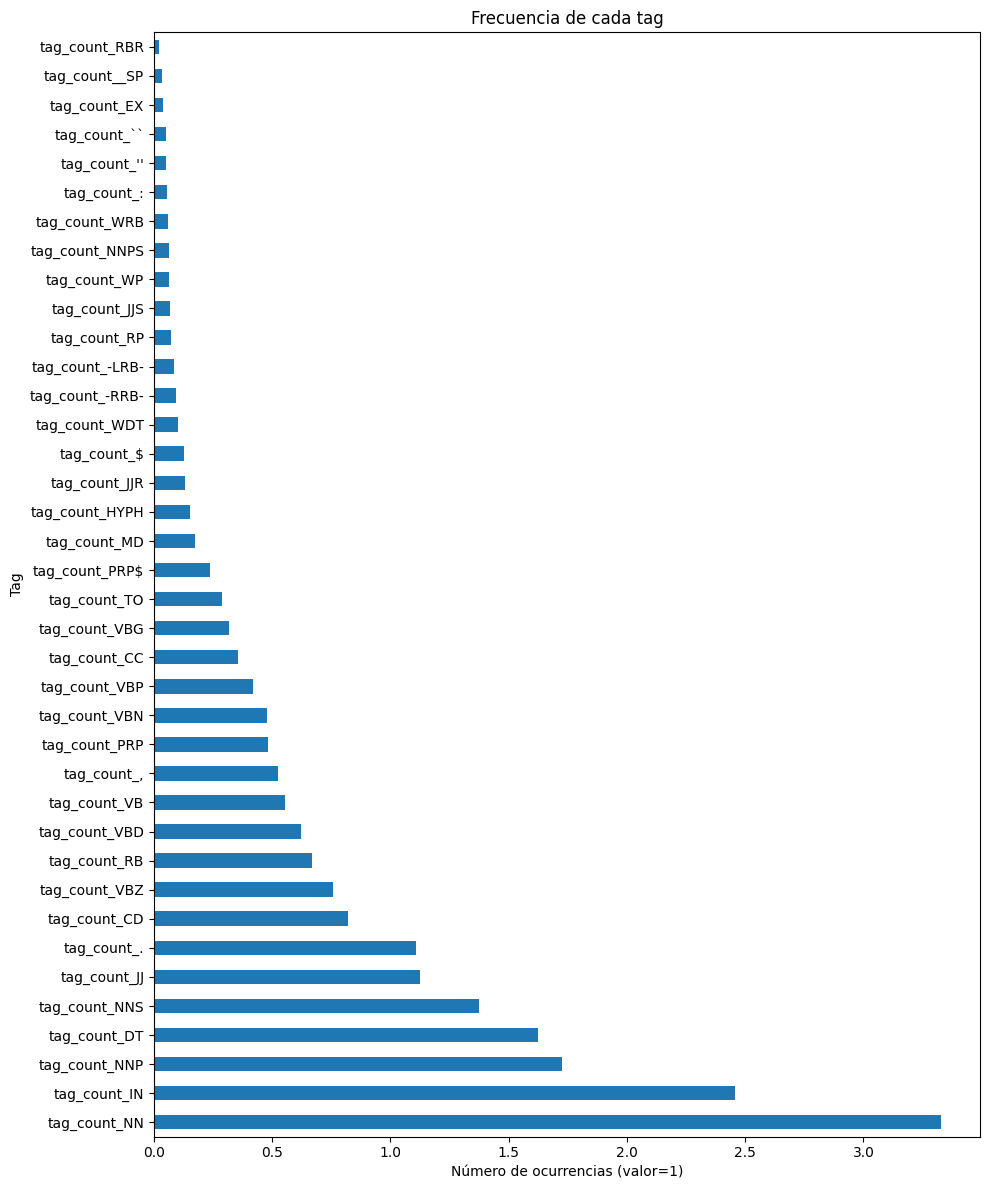

In [51]:
len(tag_df.columns.tolist())
import matplotlib.pyplot as plt

tag_counts = tag_df.mean().sort_values(ascending=False)
tag_counts_test = tag_df_test.mean().sort_values(ascending=False)

# Calcular medias por columna
mean_series = tag_df.mean(numeric_only=True)
mean_series_test = tag_df_test.mean(numeric_only=True)

# Seleccionar columnas con media mayor o igual a 0.02
cols_to_keep = mean_series[mean_series >= 0.02].index
tag_df = tag_df[cols_to_keep]

cols_to_keep_test = mean_series_test[mean_series_test >= 0.02].index
tag_df_test = tag_df_test[cols_to_keep_test]

tag_counts = tag_df.mean().sort_values(ascending=False)

tag_counts.plot(kind='barh', figsize=(10, 12), title='Frecuencia de cada tag')
plt.xlabel('Número de ocurrencias (valor=1)')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

In [52]:
# Expandir tags sin stopwords
train_df["tag_freq_without_stopwords"] = df["tag_freq_without_stopwords"].apply(clean_counter)
tag_df_no_stopwords = train_df["tag_freq_without_stopwords"].apply(pd.Series).fillna(0).astype(int)
tag_df_no_stopwords.columns = [f"tag_count_{col}" for col in tag_df_no_stopwords.columns]
len(tag_df_no_stopwords.columns.tolist())

test_df["tag_freq_without_stopwords"] = test_df["tag_freq_without_stopwords"].apply(clean_counter)
tag_df_no_stopwords_test = test_df["tag_freq_without_stopwords"].apply(pd.Series).fillna(0).astype(int)
tag_df_no_stopwords_test.columns = [f"tag_count_{col}" for col in tag_df_no_stopwords_test.columns]
len(tag_df_no_stopwords_test.columns.tolist())

34

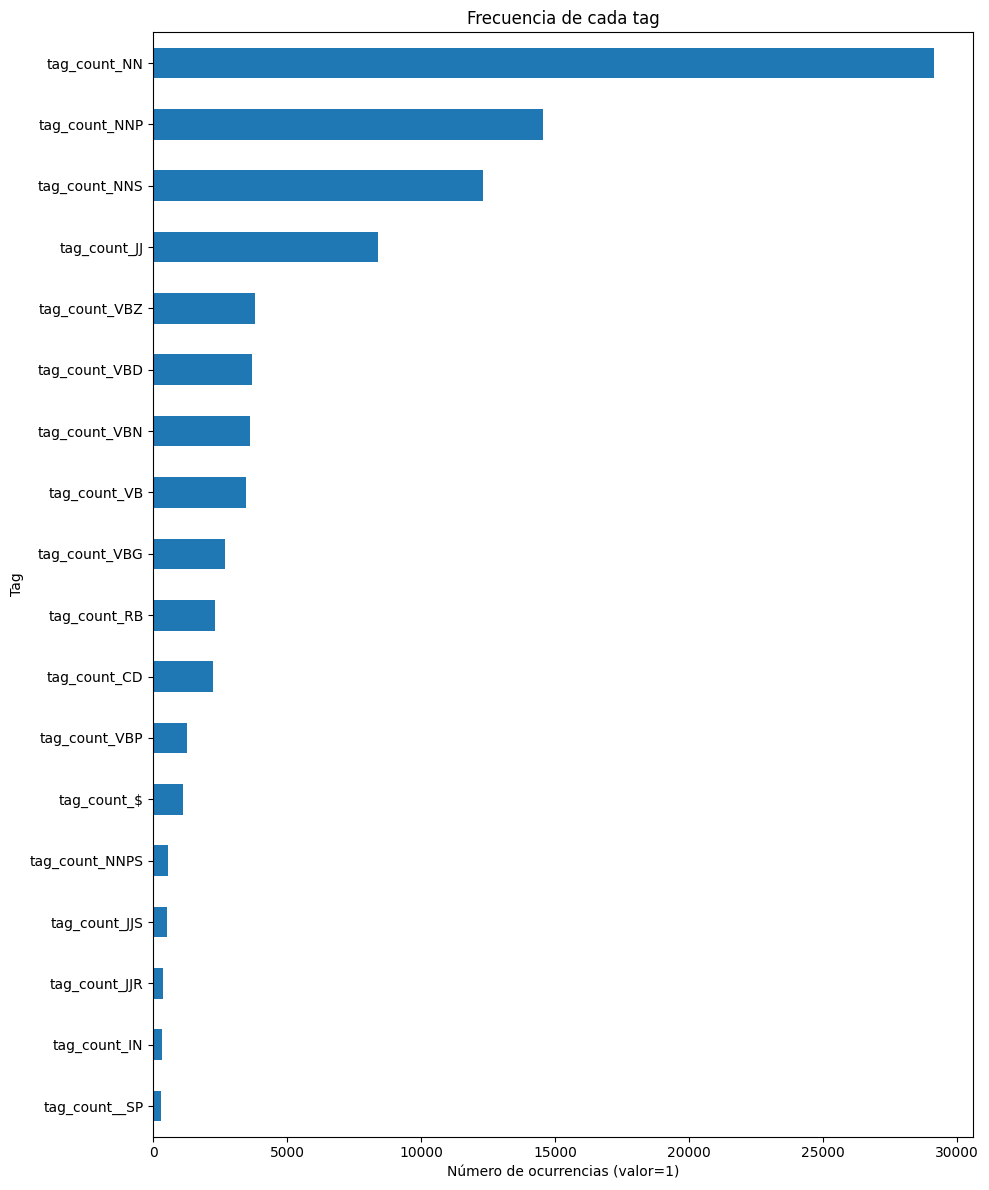

In [53]:
# Calcular medias solo sobre tag_df_no_stopwords
mean_series = tag_df_no_stopwords.mean()
mean_series_test = tag_df_no_stopwords_test.mean()

# Seleccionar columnas con media >= 0.02
cols_to_keep = mean_series[mean_series >= 0.02].index
cols_to_keep_test = mean_series_test[mean_series_test >= 0.02].index

# Filtrar el propio DataFrame con columnas válidas
tag_df_no_stopwords = tag_df_no_stopwords[cols_to_keep]
tag_df_no_stopwords_test = tag_df_no_stopwords_test[cols_to_keep_test]

# Volver a calcular para graficar solo lo que quedó
tag_counts = tag_df_no_stopwords.sum().sort_values()

# Graficar
tag_counts.plot(kind='barh', figsize=(10, 12), title='Frecuencia de cada tag')
plt.xlabel('Número de ocurrencias (valor=1)')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

In [54]:
len(tag_counts)

18

In [55]:
train_df[tag_df_no_stopwords.columns] = tag_df_no_stopwords
test_df[tag_df_no_stopwords_test.columns] = tag_df_no_stopwords_test
train_df.columns

Index(['label', 'statement', 'subject', 'speaker', 'speaker_job', 'state_info',
       'party_affiliation', 'party_affiliation_uni',
       'party_affiliation_category_map', 'tag_freq', 'entities',
       'num_tokens_without_stopwords', 'tag_freq_without_stopwords',
       'processed_subject', 'speaker_entities', 'speaker_type',
       'speaker_job_tokens', 'state_info_tokens', 'party_affiliation_tokens',
       'statement_text', 'statement_tokens_no_stopwords',
       'statement_text_no_stopwords', 'num_stopwords_tokens',
       'num_tokens_group', 'lemma_count', 'lemma_count_no_stopwords',
       'lemma_bin', 'lemma_bin_no_stopwords', 'tag_freq_clean',
       'tag_count_NNP', 'tag_count_NN', 'tag_count_JJ', 'tag_count_NNS',
       'tag_count_VBN', 'tag_count_VB', 'tag_count_VBZ', 'tag_count_RB',
       'tag_count_VBD', 'tag_count_VBG', 'tag_count_JJS', 'tag_count_CD',
       'tag_count_VBP', 'tag_count_IN', 'tag_count_JJR', 'tag_count_$',
       'tag_count_NNPS', 'tag_count__SP'],
  

In [56]:
drop_cols = ["tag_freq","tag_freq_without_stopwords","tag_freq_clean"]
train_df = train_df.drop(columns = drop_cols)
test_df = test_df.drop(columns = drop_cols)

### Subject

Para reflejar el efecto de subject, vamos a utilizarla como variable de texto como ya se ha hecho anteriormente, a partir de los tokens. En caso de que no funcione, se usará encoding sobre `processed_subject`, su versión tokenizada. Por tanto, descartamos `subject` y obtendremos dummies:

In [57]:
test_df["processed_subject"]

0       ['campaign-finance', 'ethics', 'government-reg...
1                                           ['elections']
2         ['health-care', 'immigration', 'public-health']
3       ['federal-budget', 'medicare', 'social-security']
4                ['federal-budget', 'new-hampshire-2012']
                              ...                        
3831           ['job-accomplishments', 'message-machine']
3832                                           ['ethics']
3833                          ['abortion', 'health-care']
3834                                           ['sports']
3835                                            ['taxes']
Name: processed_subject, Length: 3836, dtype: object

In [58]:
# Transformamos a lista
train_df["processed_subject"] = df["processed_subject"].apply(ast.literal_eval)
test_df["processed_subject"] = test_df["processed_subject"].apply(ast.literal_eval)

train_df["subject_text"] = train_df["processed_subject"].apply(lambda x: " ".join(x))
test_df["subject_text"] = test_df["processed_subject"].apply(lambda x: " ".join(x))

train_df["subject_text"]

0                           china foreign-policy military
1                                             health-care
2                corporations pundits taxes abc-news-week
3       candidates-biography children ethics families ...
4                          health-care labor state-budget
                              ...                        
8945           pensions public-service retirement workers
8946                  medicare message-machine retirement
8947                                          health-care
8948                                    elections history
8949                              federal-budget military
Name: subject_text, Length: 8950, dtype: object

In [59]:
import ast

# Convertir strings tipo "[tax, healthcare]" en listas reales
train_df["processed_subject"] = df["processed_subject"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

test_df["processed_subject"] = test_df["processed_subject"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Aplanar la lista de subjects
all_subjects = [item for sublist in train_df["processed_subject"] for item in sublist]
all_subjects = list(set(all_subjects))

In [60]:
# Seleccionar los más comunes
subject_counts = Counter(all_subjects)
#top_n = 100

#top_subjects = [s for s, count in subject_counts.most_common(top_n)]
#top_subjects

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=all_subjects)

# Entrenamiento
subjects_train = pd.DataFrame(
    mlb.fit_transform(train_df["processed_subject"]),
    columns=[f"subject_{s}" for s in mlb.classes_],
    index=train_df.index
)

# Test
subjects_test = pd.DataFrame(
    mlb.transform(test_df["processed_subject"]),
    columns=[f"subject_{s}" for s in mlb.classes_],
    index=test_df.index
)

In [62]:
subjects_train

,subject_bankruptcy,subject_oil-spill,subject_ebola,subject_autism,subject_legal-issues,subject_homeland-security,subject_urban,subject_medicare,subject_criminal-justice,subject_pensions,...,subject_florida-amendments,subject_alcohol,subject_consumer-safety,subject_occupy-wall-street,subject_debt,subject_abortion,subject_natural-disasters,subject_social-security,subject_education,subject_debates
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8946,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora los datos de entrenamiento contienen los temas en formato dummies, más reconocible para catboost. No obstante, se ha visto que las variables por separado no presentan apenas importancia comparado con statement. Por tanto, se filtran los subjects con mayor y menor tasa de label y se categorizan como high_risk y low_risk. Para ello, consideramos clipping:

In [63]:
subject_cols=subjects_train.columns.tolist()

# Aseguramos las dimensiones
subjects_train["label"] = df["label"]
print(subjects_train.shape)
print(df.shape)

subject_stats = pd.DataFrame({
    'label_rate': [subjects_train.loc[subjects_train[col] == 1, 'label'].mean() for col in subject_cols],
    'count': [subjects_train[col].sum() for col in subject_cols]
}, index=subject_cols).sort_values(by='label_rate', ascending=False)
subject_stats.describe(percentiles=[0.15,0.20,0.30,0.35,0.4,0.55])

(8950, 143)
(8950, 31)


,label_rate,count
count,142.000000,142.000000
mean,0.650909,135.739437
std,0.138465,182.495067
min,0.000000,1.000000
15%,0.575288,20.300000
20%,0.588848,25.000000
30%,0.613111,39.000000
35%,0.625735,43.700000
40%,0.636989,48.800000
50%,0.657736,66.500000


Filtramos subjects por rate, pero solo de aquellos que tienen buen soporte, basándonos en las estadísticas.

In [64]:
MIN_COUNT = 50
filtered_subjects = subject_stats[subject_stats["count"] >= MIN_COUNT]

high_risk_subjects = filtered_subjects.sort_values(by="label_rate", ascending=False).head(5).index.tolist()
low_risk_subjects = filtered_subjects.sort_values(by="label_rate", ascending=True).head(5).index.tolist()

subjects_train["subject_high_risk"] = subjects_train[high_risk_subjects].sum(axis=1).gt(0).astype(int)
subjects_train["subject_low_risk"] = subjects_train[low_risk_subjects].sum(axis=1).gt(0).astype(int)

# Marcamos esas columnas en test asegurando que estén todas
for col in high_risk_subjects + low_risk_subjects:
    if col not in test_df.columns:
        test_df[col] = 0

test_df["subject_high_risk"] = test_df[high_risk_subjects].sum(axis=1).gt(0).astype(int)
test_df["subject_low_risk"] = test_df[low_risk_subjects].sum(axis=1).gt(0).astype(int)

subjects_train["subject_low_risk"].sum()

np.int64(565)

In [65]:
# Calcular cobertura en train_df
subjects_train["subject_high_risk"] = subjects_train[high_risk_subjects].sum(axis=1).gt(0).astype(int)
subjects_train["subject_low_risk"] = subjects_train[low_risk_subjects].sum(axis=1).gt(0).astype(int)

# Cobertura total (en %)
high_risk_coverage = subjects_train["subject_high_risk"].mean() * 100
low_risk_coverage = subjects_train["subject_low_risk"].mean() * 100

print(f"Cobertura subject_high_risk: {high_risk_coverage:.2f}% de las filas")
print(f"Cobertura subject_low_risk: {low_risk_coverage:.2f}% de las filas")

Cobertura subject_high_risk: 6.89% de las filas
Cobertura subject_low_risk: 6.31% de las filas


In [66]:
subjects_train["label"].mean() # analizar para ser buen predictor 

np.float64(0.647486033519553)

In [67]:
print(subjects_train.groupby("subject_high_risk")["label"].mean())
print(subjects_train.groupby("subject_low_risk")["label"].mean())

subject_high_risk
0    0.636145
1    0.800648
Name: label, dtype: float64
subject_low_risk
0    0.655575
1    0.527434
Name: label, dtype: float64


Vemos que `low` no tendrá el carácter predictivo que esperamos. Igualmente, en esta variable, sigue habiendo más proporcion de 0 que de 1, por lo que puede no ser buen predictor. Cabe destacar que el dataset está desbalanceado, aunque lo estemos comparando con el baseline.

### Speaker Job

Para speaker job vamos a integrar sus tokens, guardarlos en `speaker_job_text` y usarlos como texto. la variable original no se usará directamente. 

In [68]:
import ast

# Transformamos a lista
train_df["speaker_job_tokens"] = df["speaker_job_tokens"].apply(ast.literal_eval)

train_df["speaker_job_text"] = train_df["speaker_job_tokens"].apply(lambda x: " ".join(x))
train_df.head(2)

# Transformamos a lista
test_df["speaker_job_tokens"] = test_df["speaker_job_tokens"].apply(ast.literal_eval)

test_df["speaker_job_text"] = test_df["speaker_job_tokens"].apply(lambda x: " ".join(x))

La lista de tokens no es procesable para CatBoost, por lo que se elimina del conjunto.

### State info

Es una variable puramente categórica, ya procesada y con interés predictivo. Se añade a la lista de features categóricas. `state_info_tokens` contiene la misma información, se descarta. 

In [69]:
train_df = drop(train_df,"state_info_tokens")
test_df = drop(test_df,"state_info_tokens")

### Party_affiliation

Tenemos tres variables que hacen referencia a esta información:
- `party_affiliation`: variable original sin limpiar, se descarta.
- `party_affiliation_uni`: variable procesada, observar cardinalidad.
- `party_afiliation_category_map`: variable mapeada manualmente, comparar rendimiento con la anterior.
- `party_affiliation_tokens`: versión tokenizada, se quita

Descartamos la original:    

In [70]:
df["party_affiliation_tokens"].unique() # los guiones introducen ruido

array(["['republican']", "['democrat']", "['none']", "['independent']",
       "['journalist']", "['organization']",
       "['talk', '-', 'show', '-', 'host']",
       "['tea', '-', 'party', '-', 'member']", "['activist']",
       "['constitution', '-', 'party']", "['libertarian']",
       "['state', '-', 'official']", "['columnist']", "['newsmaker']",
       "['moderate']", "['business', '-', 'leader']",
       "['labor', '-', 'leader']", "['education', '-', 'official']",
       "['county', '-', 'commissioner']", "['green']",
       "['liberal', '-', 'party', '-', 'canada']",
       "['ocean', '-', 'state', '-', 'tea', '-', 'party', '-', 'action']",
       "['government', '-', 'body']",
       "['democratic', '-', 'farmer', '-', 'labor']"], dtype=object)

In [71]:
train_df = drop(train_df,"party_affiliation")
test_df = drop(test_df,"party_affiliation")

train_df = drop(train_df,"party_affiliation_tokens")
test_df = drop(test_df,"party_affiliation_tokens")

train_df.columns.tolist()

['label',
 'statement',
 'subject',
 'speaker',
 'speaker_job',
 'state_info',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'entities',
 'num_tokens_without_stopwords',
 'processed_subject',
 'speaker_entities',
 'speaker_type',
 'speaker_job_tokens',
 'statement_text',
 'statement_tokens_no_stopwords',
 'statement_text_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group',
 'lemma_count',
 'lemma_count_no_stopwords',
 'lemma_bin',
 'lemma_bin_no_stopwords',
 'tag_count_NNP',
 'tag_count_NN',
 'tag_count_JJ',
 'tag_count_NNS',
 'tag_count_VBN',
 'tag_count_VB',
 'tag_count_VBZ',
 'tag_count_RB',
 'tag_count_VBD',
 'tag_count_VBG',
 'tag_count_JJS',
 'tag_count_CD',
 'tag_count_VBP',
 'tag_count_IN',
 'tag_count_JJR',
 'tag_count_$',
 'tag_count_NNPS',
 'tag_count__SP',
 'subject_text',
 'speaker_job_text']

Contamos los valores únicos en `_uni`

In [72]:
df["party_affiliation_uni"].nunique()

12

Se trata de un valor aceptable para pasarlo como categórica al modelo. Se añade.

In [73]:
df["party_affiliation_category_map"].nunique()

4

Dado que la cardinalidad de `_uni` es adecuada y esta variable viene de un mapeo manual, se elimina del modelo provisionalmente. Sin embargo, se ha observado alta dependencia del modelo de esta variable en algunos casos.

### Entities

In [74]:
df["entities"]

0         Entidad Tipo de Entidad                Expli...
1                         Entidad Tipo de Entidad  \\n...
2                 Entidad Tipo de Entidad             ...
3       Empty DataFrame\nColumns: [Entidad, Tipo de En...
4            Entidad Tipo de Entidad                Ex...
                              ...                        
8945            Entidad Tipo de Entidad               ...
8946                       Entidad Tipo de Entidad  \\...
8947                 Entidad Tipo de Entidad          ...
8948                  Entidad Tipo de Entidad  \\n0   ...
8949          Entidad Tipo de Entidad                 ...
Name: entities, Length: 8950, dtype: object

In [75]:
import re

def extract_entities(entity_str):
    if not isinstance(entity_str, str) or "Tipo de Entidad" not in entity_str:
        return []

    try:
        lines = entity_str.strip().split("\n")
        lines = lines[1:]
        entities = []
        for line in lines:
                matches = re.findall(r"\b\w*[A-Z]{3,}\w*\b", line)
                if matches:
                    entities+=matches
        return entities if entities else ["OTHER"]
    except:
        return []

# Aplicar al DataFrame
train_df["entity_list"] = df["entities"].apply(extract_entities)
test_df["entity_list"] = test_df["entities"].apply(extract_entities)

train_df["entity_list"]

#train_df['entity_cat'] = train_df['entity_list'].apply(
#    lambda x: '_'.join(sorted(set(x))) if isinstance(x, list) else x
#)
#sorted(train_df['entity_cat'].unique().tolist())

0                                [GPE]
1                [DATE, EVENT, PERSON]
2                                [ORG]
3                              [OTHER]
4                                [GPE]
                     ...              
8945                    [GPE, ORDINAL]
8946                             [ORG]
8947                        [ORG, GPE]
8948    [NORP, DATE, CARDINAL, PERSON]
8949                           [MONEY]
Name: entity_list, Length: 8950, dtype: object

In [76]:
from sklearn.preprocessing import MultiLabelBinarizer

train_df["entity_list"] = train_df["entity_list"].apply(lambda x: x if isinstance(x, list) else [])
test_df["entity_list"] = test_df["entity_list"].apply(lambda x: x if isinstance(x, list) else [])

# Binarizar
mlb = MultiLabelBinarizer()
entity_dummies = pd.DataFrame(
    mlb.fit_transform(train_df["entity_list"]),
    columns=[f"entity_{cls}" for cls in mlb.classes_],
    index=train_df.index
)

entity_counts = entity_dummies.sum().sort_values(ascending=False)
entity_dummies["label"] = df["label"]
entity_dummies

mlb = MultiLabelBinarizer()
entity_dummies_test = pd.DataFrame(
    mlb.fit_transform(test_df["entity_list"]),
    columns=[f"entity_{cls}" for cls in mlb.classes_],
    index=test_df.index
)

entity_counts_test = entity_dummies_test.sum().sort_values(ascending=False)
entity_dummies_test

,entity_CARDINAL,entity_DATE,entity_EVENT,entity_FAC,entity_GPE,entity_LANGUAGE,entity_LAW,entity_LOC,entity_MONEY,entity_NORP,entity_ORDINAL,entity_ORG,entity_OTHER,entity_PERCENT,entity_PERSON,entity_PRODUCT,entity_QUANTITY,entity_TIME
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3832,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3833,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
entity_cols = [col for col in entity_dummies.columns if col.startswith("entity_")]

entity_stats = pd.DataFrame({
    "total": entity_dummies[entity_cols].sum(),
    "label_1": entity_dummies[entity_dummies["label"] == 1][entity_cols].sum()
})
entity_stats["label_rate"] = entity_stats["label_1"] / entity_stats["total"]
entity_stats = entity_stats.sort_values("label_rate", ascending=False)
entity_stats

,total,label_1,label_rate
entity_WORK_OF_ART,1,1,1.000000
entity_PERSON,2690,1934,0.718959
entity_LOC,94,66,0.702128
entity_OTHER,1331,923,0.693464
entity_ORG,1296,898,0.692901
entity_LANGUAGE,12,8,0.666667
entity_MONEY,1075,700,0.651163
entity_NORP,1077,696,0.646240
entity_GPE,2689,1675,0.622908
entity_FAC,31,19,0.612903


In [78]:
N = 30  # o 10 si querés más cobertura
MIN_COUNT = 30
filtered_entities = entity_stats[entity_stats["total"] >= MIN_COUNT]
filtered_entities

,total,label_1,label_rate
entity_PERSON,2690,1934,0.718959
entity_LOC,94,66,0.702128
entity_OTHER,1331,923,0.693464
entity_ORG,1296,898,0.692901
entity_MONEY,1075,700,0.651163
entity_NORP,1077,696,0.646240
entity_GPE,2689,1675,0.622908
entity_FAC,31,19,0.612903
entity_QUANTITY,64,39,0.609375
entity_CARDINAL,1869,1097,0.586945


In [79]:
high_risk_entities = filtered_entities.head(N).index.tolist()
low_risk_entities = filtered_entities.tail(N).index.tolist()

In [80]:
train_df["entity_high_risk"] = entity_dummies[high_risk_entities].sum(axis=1).gt(0).astype(int)
train_df["entity_low_risk"] = entity_dummies[low_risk_entities].sum(axis=1).gt(0).astype(int)

# Marcamos esas columnas en test asegurando que estén todas
for col in high_risk_entities + low_risk_entities:
    if col not in test_df.columns:
        test_df[col] = 0

test_df["entity_high_risk"] = test_df[high_risk_entities].sum(axis=1).gt(0).astype(int)
test_df["entity_low_risk"] = test_df[low_risk_entities].sum(axis=1).gt(0).astype(int)

Reducir cardinalidad para no meter ruido. Para ello, vamos a quedarnos con 10 características (después de observar su frecuencia)

In [81]:
import pandas as pd

# Definir umbral 
threshold = 100
entities_to_keep = entity_stats[entity_stats["total"] >= threshold].index.tolist()
entities_to_drop = entity_stats[entity_stats["total"] < threshold].index.tolist()

# Mostrar
print("Entidades frecuentes (a conservar):")
print(entities_to_keep)
print("Entidades poco frecuentes (a eliminar):")
print(entities_to_drop)

# Crear nueva columna 'entity_OTHER' en entity_dummies
entity_dummies["entity_OTHER"] = entity_dummies[entities_to_drop].any(axis=1).astype(int)
entity_dummies

Entidades frecuentes (a conservar):
['entity_PERSON', 'entity_OTHER', 'entity_ORG', 'entity_MONEY', 'entity_NORP', 'entity_GPE', 'entity_CARDINAL', 'entity_DATE', 'entity_PERCENT', 'entity_ORDINAL']
Entidades poco frecuentes (a eliminar):
['entity_WORK_OF_ART', 'entity_LOC', 'entity_LANGUAGE', 'entity_FAC', 'entity_QUANTITY', 'entity_EVENT', 'entity_TIME', 'entity_PRODUCT', 'entity_LAW']


,entity_CARDINAL,entity_DATE,entity_EVENT,entity_FAC,entity_GPE,entity_LANGUAGE,entity_LAW,entity_LOC,entity_MONEY,entity_NORP,entity_ORDINAL,entity_ORG,entity_OTHER,entity_PERCENT,entity_PERSON,entity_PRODUCT,entity_QUANTITY,entity_TIME,entity_WORK_OF_ART,label
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8946,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8947,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8948,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


### Speaker_type

In [82]:
import ast

train_df["speaker_type"] = df["speaker_type"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

test_df["speaker_type"] = test_df["speaker_type"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

In [83]:
train_df["speaker_type"]

0         [PERSON]
1         [PERSON]
2         [PERSON]
3         [PERSON]
4       [ORG, GPE]
           ...    
8945         [ORG]
8946      [PERSON]
8947      [PERSON]
8948      [PERSON]
8949      [PERSON]
Name: speaker_type, Length: 8950, dtype: object

In [84]:
# Binarizar
mlb = MultiLabelBinarizer()
speaker_type_dummies = pd.DataFrame(
    mlb.fit_transform(train_df["speaker_type"]),
    columns=[f"speaker_type_{cls}" for cls in mlb.classes_],
    index=train_df.index
)

# Binarizar
mlb = MultiLabelBinarizer()
speaker_type_dummies_test = pd.DataFrame(
    mlb.fit_transform(test_df["speaker_type"]),
    columns=[f"speaker_type_{cls}" for cls in mlb.classes_],
    index=test_df.index
)

speaker_type_counts = speaker_type_dummies.sum().sort_values(ascending=False)
speaker_type_counts_test = speaker_type_dummies_test.sum().sort_values(ascending=False)
speaker_type_counts

speaker_type_PERSON      5995
speaker_type_ORG          780
speaker_type_GPE          264
speaker_type_NORP         188
speaker_type_CARDINAL      41
speaker_type_DATE          16
speaker_type_PRODUCT       13
speaker_type_ORDINAL        7
speaker_type_FAC            7
speaker_type_EVENT          4
speaker_type_PERCENT        2
speaker_type_LAW            1
speaker_type_TIME           1
dtype: int64

In [85]:
speaker_type_freq = speaker_type_counts.reset_index()
speaker_type_freq.columns = ["speaker_type", "frequency"]
speaker_type_freq

,speaker_type,frequency
0,speaker_type_PERSON,5995
1,speaker_type_ORG,780
2,speaker_type_GPE,264
3,speaker_type_NORP,188
4,speaker_type_CARDINAL,41
5,speaker_type_DATE,16
6,speaker_type_PRODUCT,13
7,speaker_type_ORDINAL,7
8,speaker_type_FAC,7
9,speaker_type_EVENT,4


In [86]:
speaker_type_dummies

,speaker_type_CARDINAL,speaker_type_DATE,speaker_type_EVENT,speaker_type_FAC,speaker_type_GPE,speaker_type_LAW,speaker_type_NORP,speaker_type_ORDINAL,speaker_type_ORG,speaker_type_PERCENT,speaker_type_PERSON,speaker_type_PRODUCT,speaker_type_TIME
0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,0,0,0,0,0,0,0,0,1,0,0,0,0
8946,0,0,0,0,0,0,0,0,0,0,1,0,0
8947,0,0,0,0,0,0,0,0,0,0,1,0,0
8948,0,0,0,0,0,0,0,0,0,0,1,0,0


In [87]:
# Definir umbral 
threshold = 100
speaker_to_keep = speaker_type_freq[speaker_type_freq["frequency"] >= threshold]["speaker_type"].tolist()
speaker_to_drop = speaker_type_freq[speaker_type_freq["frequency"] < threshold]["speaker_type"].tolist()

# Mostrar
print("Speakers frecuentes (a conservar):")
print(speaker_to_keep)
print("speakers poco frecuentes (a eliminar):")
print(speaker_to_drop)

Speakers frecuentes (a conservar):
['speaker_type_PERSON', 'speaker_type_ORG', 'speaker_type_GPE', 'speaker_type_NORP']
speakers poco frecuentes (a eliminar):
['speaker_type_CARDINAL', 'speaker_type_DATE', 'speaker_type_PRODUCT', 'speaker_type_ORDINAL', 'speaker_type_FAC', 'speaker_type_EVENT', 'speaker_type_PERCENT', 'speaker_type_LAW', 'speaker_type_TIME']


In [88]:
speaker_type_dummies["speaker_OTHER"] = speaker_type_dummies[speaker_to_drop].any(axis=1).astype(int)
speaker_type_dummies = speaker_type_dummies.drop(columns=speaker_to_drop)
speaker_type_dummies

,speaker_type_GPE,speaker_type_NORP,speaker_type_ORG,speaker_type_PERSON,speaker_OTHER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,1,0,1,0,0
...,...,...,...,...,...
8945,0,0,1,0,0
8946,0,0,0,1,0
8947,0,0,0,1,0
8948,0,0,0,1,0


In [89]:
for col in speaker_to_keep + speaker_to_drop:
    if col not in speaker_type_dummies_test.columns:
        speaker_type_dummies_test[col] = 0
        
speaker_type_dummies_test["speaker_OTHER"] = speaker_type_dummies_test[speaker_to_drop].any(axis=1).astype(int)
speaker_type_dummies_test = speaker_type_dummies_test.drop(columns=speaker_to_drop)
speaker_type_dummies_test

,speaker_type_GPE,speaker_type_LANGUAGE,speaker_type_NORP,speaker_type_ORG,speaker_type_PERSON,speaker_OTHER
0,0,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
3831,0,0,0,0,1,0
3832,0,0,0,0,0,0
3833,0,0,0,0,1,0
3834,0,0,0,0,0,0


In [90]:
train_df = pd.concat([train_df,speaker_type_dummies[speaker_to_keep]],axis=1)
test_df = pd.concat([test_df,speaker_type_dummies_test[speaker_to_keep]],axis=1)

In [91]:
train_df.columns.tolist()

['label',
 'statement',
 'subject',
 'speaker',
 'speaker_job',
 'state_info',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'entities',
 'num_tokens_without_stopwords',
 'processed_subject',
 'speaker_entities',
 'speaker_type',
 'speaker_job_tokens',
 'statement_text',
 'statement_tokens_no_stopwords',
 'statement_text_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group',
 'lemma_count',
 'lemma_count_no_stopwords',
 'lemma_bin',
 'lemma_bin_no_stopwords',
 'tag_count_NNP',
 'tag_count_NN',
 'tag_count_JJ',
 'tag_count_NNS',
 'tag_count_VBN',
 'tag_count_VB',
 'tag_count_VBZ',
 'tag_count_RB',
 'tag_count_VBD',
 'tag_count_VBG',
 'tag_count_JJS',
 'tag_count_CD',
 'tag_count_VBP',
 'tag_count_IN',
 'tag_count_JJR',
 'tag_count_$',
 'tag_count_NNPS',
 'tag_count__SP',
 'subject_text',
 'speaker_job_text',
 'entity_list',
 'entity_high_risk',
 'entity_low_risk',
 'speaker_type_PERSON',
 'speaker_type_ORG',
 'speaker_type_GPE',
 'speaker_type_NORP']

In [159]:
df_train_clean = train_df.copy()
df_test_clean = test_df.copy()

def join_unique_or_single(x):
    if isinstance(x, list):
        if len(x) == 0:
            return ''
        elif len(x) == 1 or x[0] == x[1]:
            return str(x[0])
        else:
            return '_'.join(x)
    return x

df_train_clean["speaker_type"] = df_train_clean["speaker_type"].apply(join_unique_or_single)
df_test_clean["speaker_type"] = df_test_clean["speaker_type"].apply(join_unique_or_single)

df_train_clean["speaker_type"].unique()

cols_to_drop = [col for col in df_train_clean.columns if col.startswith('speaker_type_')]
df_train_clean = df_train_clean.drop(columns=cols_to_drop)

cols_to_drop = [col for col in df_train_clean.columns if col.startswith('speaker_type_')]
df_test_clean = df_test_clean.drop(columns=cols_to_drop)
df_train_clean

,label,statement,subject,speaker,speaker_job,state_info,party_affiliation_uni,party_affiliation_category_map,entities,num_tokens_without_stopwords,...,tag_count_IN,tag_count_JJR,tag_count_$,tag_count_NNPS,tag_count__SP,subject_text,speaker_job_text,entity_list,entity_high_risk,entity_low_risk
0,1,china is in the south china sea and buildinga ...,"china,foreign-policy,military",donald-trump,president-elect,new_york,republican,political-affiliation,Entidad Tipo de Entidad Expli...,10,...,0,0,0,0,0,china foreign-policy military,president - elect,[GPE],1,1
1,0,with the resources it takes to execute just ov...,health-care,chris-dodd,u.s. senator,connecticut,democrat,political-affiliation,Entidad Tipo de Entidad \\n...,12,...,0,0,0,0,0,health-care,u.s . senator,"[DATE, EVENT, PERSON]",1,1
2,0,the wisconsin governor has proposed tax giveaw...,"corporations,pundits,taxes,abc-news-week",donna-brazile,political commentator,washington_dc,democrat,political-affiliation,Entidad Tipo de Entidad ...,6,...,0,0,0,0,0,corporations pundits taxes abc-news-week,political commentator,[ORG],1,1
3,1,says her representation of an exboyfriend who ...,"candidates-biography,children,ethics,families,...",rebecca-bradley,non-define,non-define,none,other-political-groups,"Empty DataFrame\nColumns: [Entidad, Tipo de En...",11,...,0,0,0,0,0,candidates-biography children ethics families ...,non - define,[OTHER],1,1
4,0,at protests in wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,non-define,wisconsin,republican,political-affiliation,Entidad Tipo de Entidad Ex...,12,...,0,0,0,0,0,health-care labor state-budget,non - define,[GPE],1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,1,if rhode island does a hybrid retirement plan ...,"pensions,public-service,retirement,workers",lincoln-chafee,non-define,rhode_island,democrat,political-affiliation,Entidad Tipo de Entidad ...,7,...,0,0,0,0,0,pensions public-service retirement workers,non - define,"[GPE, ORDINAL]",1,1
8946,1,the new health care law will force seniors int...,"medicare,message-machine,retirement",dan-coats,non-define,indiana,republican,political-affiliation,Entidad Tipo de Entidad \\...,12,...,0,0,0,0,0,medicare message-machine retirement,non - define,[ORG],1,1
8947,0,the health insurance plan that members of cong...,health-care,steve-southerland,"u.s. representative, florida district 2",florida,republican,political-affiliation,Entidad Tipo de Entidad ...,11,...,0,0,0,0,0,health-care,"u.s . representative , florida district 2","[ORG, GPE]",1,1
8948,1,no one in american history has moved from a ju...,"elections,history",newt-gingrich,"co-host on cnn's ""crossfire""",georgia,republican,political-affiliation,Entidad Tipo de Entidad \\n0 ...,10,...,0,0,0,0,0,elections history,"co - host on cnn 's "" crossfire ""","[NORP, DATE, CARDINAL, PERSON]",1,1


In [160]:
tag_cols = [col for col in df_train_clean.columns if col.startswith('tag_count_')]
tag_cols

tag_cols_test = [col for col in df_test_clean.columns if col.startswith('tag_count_')]
tag_cols_test

df_train_clean['tag_count'] = df_train_clean[tag_cols].sum(axis=1)
df_test_clean['tag_count'] = df_test_clean[tag_cols_test].sum(axis=1)

df_train_clean['tag_count'].unique()

def agrupar(valor):
    if valor <= 20:
        return '<20'
    elif valor <= 50:
        return '20-50'
    elif valor <= 100:
        return '50-100'
    else:
        return '>100'

df_train_clean["tag_groups"] = df_train_clean["tag_count"].apply(agrupar)
df_test_clean["tag_groups"] = df_test_clean["tag_count"].apply(agrupar)

df_train_clean = df_train_clean.drop(columns=tag_cols)
df_test_clean = df_test_clean.drop(columns=tag_cols_test)

In [161]:
for col in df_train_clean.columns:
    if df_train_clean[col].apply(lambda x: isinstance(x, dict)).any():
        print(f"'{col}' contiene listas.")

In [169]:
cat_features = ["state_info","speaker_job","party_affiliation_uni","lemma_bin","tag_groups","speaker_type","num_tokens_group"]
text_features = ["statement_text_no_stopwords","subject_text"]
#"statement","statement_text_no_stopwords",


In [165]:
drop_cols = ["entities","speaker","speaker_job_text","entity_list","processed_subject","speaker_entities","speaker_job_tokens","statement_tokens_no_stopwords","subject","party_affiliation_category_map","statement","statement_text","lemma_bin_no_stopwords","lemma_count_no_stopwords","num_stopwords_tokens","num_tokens_without_stopwords","tag_count"]
df_train_clean = df_train_clean.drop(columns=drop_cols)
df_test_clean = df_test_clean.drop(columns=drop_cols)

In [170]:
X = df_train_clean.drop(columns=['label'])
y = df['label']

In [171]:
sorted(X.columns.tolist())

['entity_high_risk',
 'entity_low_risk',
 'lemma_bin',
 'lemma_count',
 'num_tokens_group',
 'party_affiliation_uni',
 'speaker_job',
 'speaker_type',
 'state_info',
 'statement_text_no_stopwords',
 'subject_text',
 'tag_groups']

In [172]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features, text_features=text_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features, text_features=text_features)

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg = 1,
    auto_class_weights="Balanced",  # ajustar según desbalanceo
    eval_metric='F1',      
    verbose=100,
    random_strength=0.5

)

model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.6117405	test: 0.6138855	best: 0.6138855 (0)	total: 674ms	remaining: 8m 58s
100:	learn: 0.6470379	test: 0.6107694	best: 0.6187801 (4)	total: 1m 19s	remaining: 9m 13s
200:	learn: 0.6570538	test: 0.6158227	best: 0.6187801 (4)	total: 2m 27s	remaining: 7m 19s
300:	learn: 0.6680605	test: 0.6164509	best: 0.6187837 (283)	total: 3m 31s	remaining: 5m 50s
400:	learn: 0.6797858	test: 0.6160245	best: 0.6191604 (310)	total: 4m 44s	remaining: 4m 43s
500:	learn: 0.6908192	test: 0.6137818	best: 0.6191604 (310)	total: 6m 8s	remaining: 3m 40s
600:	learn: 0.6988638	test: 0.6084566	best: 0.6191604 (310)	total: 7m 20s	remaining: 2m 25s
700:	learn: 0.7081269	test: 0.6134510	best: 0.6191604 (310)	total: 8m 32s	remaining: 1m 12s
799:	learn: 0.7181766	test: 0.6164522	best: 0.6191604 (310)	total: 9m 41s	remaining: 0us

bestTest = 0.6191603504
bestIteration = 310

Shrink model to first 311 iterations.


In [173]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicciones
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]  # para métricas probabilísticas

# Informe de clasificación
print(classification_report(y_val, y_pred))

# Matriz de confusión
print(confusion_matrix(y_val, y_pred))

# ROC AUC
print("ROC AUC:", roc_auc_score(y_val, y_proba))

              precision    recall  f1-score   support

           0       0.47      0.59      0.52       631
           1       0.74      0.63      0.68      1159

    accuracy                           0.62      1790
   macro avg       0.60      0.61      0.60      1790
weighted avg       0.64      0.62      0.62      1790

[[372 259]
 [426 733]]
ROC AUC: 0.6420270493854339


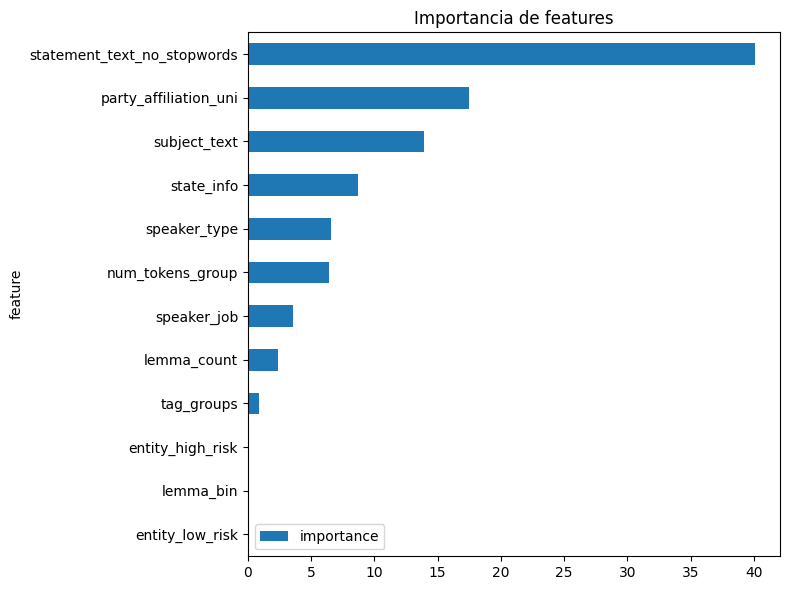

In [174]:
feat_imp = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.get_feature_importance()
}).sort_values(by='importance', ascending=False)

# Visualizar top 20
feat_imp.head(20).plot.barh(x='feature', y='importance', figsize=(8, 6), title='Importancia de features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_features = (
    pd.DataFrame({
        'feature': model.feature_names_,
        'importance': model.get_feature_importance()
    })
    .sort_values(by='importance', ascending=False)
    .head(7)['feature']
    .tolist()
)

X_top7 = X[top_features]
y = df_train_clean['label']

Detectado enmascaramiento de `party_affiliation_uni`. Se sustituye por sus "equivalentes". Al quitarla, comienzan a dominar las variables relacionadas con el `statement`, que estaría bien si el resto de variables aportaran importancia, pero el valor de ésta es muy superior. 

['entity_high_risk',
 'entity_low_risk',
 'lemma_bin',
 'lemma_bin_no_stopwords',
 'lemma_count',
 'lemma_count_no_stopwords',
 'num_stopwords_tokens',
 'num_tokens_group',
 'num_tokens_without_stopwords',
 'party_affiliation_uni',
 'speaker_job',
 'speaker_type',
 'state_info',
 'statement_text_no_stopwords',
 'subject_text',
 'tag_count',
 'tag_groups']

In [175]:
# Subir a Kaggle

In [176]:
test_pool = Pool(data=df_test_clean,
                 cat_features=cat_features, 
                 text_features=text_features)

In [177]:
import datetime
y_pred_test = model.predict(test_pool)
# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test_id,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/CatBoost_NewProcessing_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/CatBoost_NewProcessing_2025-05-18_18-09-07.csv


In [ ]:
test_df.columns.tolist()

In [ ]:
train_df.columns.tolist()